In [1]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,#unetr
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

print_config()

MONAI version: 1.2.dev2312
Numpy version: 1.21.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.h

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp394__lgx


In [4]:
# num_samples = 4

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-175,
#             a_max=250,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=(1.5, 1.5, 2.0),
#             mode=("bilinear", "nearest"),
#         ),
#         EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(96, 96, 96),
#             pos=1,
#             neg=1,
#             num_samples=num_samples,
#             image_key="image",
#             image_threshold=0,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[0],
#             prob=0.10,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[1],
#             prob=0.10,
#         ),
#         RandFlipd(
#             keys=["image", "label"],
#             spatial_axis=[2],
#             prob=0.10,
#         ),
#         RandRotate90d(
#             keys=["image", "label"],
#             prob=0.10,
#             max_k=3,
#         ),
#         RandShiftIntensityd(
#             keys=["image"],
#             offsets=0.10,
#             prob=0.50,
#         ),
#     ]
# )
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=(1.5, 1.5, 2.0),
#             mode=("bilinear", "nearest"),
#         ),
#         EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
#     ]
# )
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [5]:
split_json = "dataset_0.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:07<00:00,  1.19s/it]


image shape: torch.Size([1, 314, 214, 234]), label shape: torch.Size([1, 314, 214, 234])


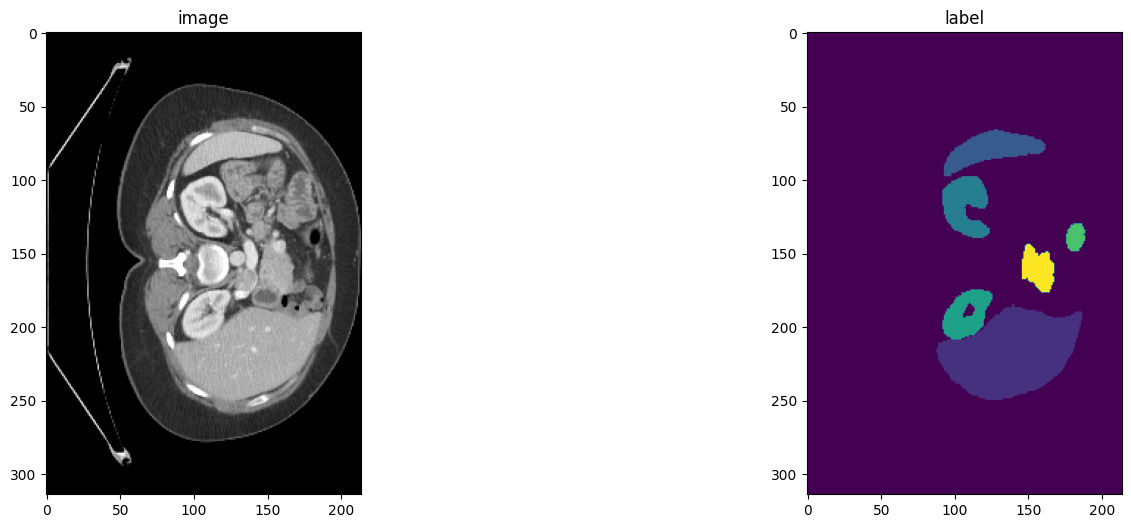

In [6]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [11]:
weight = torch.load("/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1/swinunetr_best_metric_model.pth")
model.load_state_dict(weight)
print("Using pretrained self-supervied Swin UNETR backbone weights !")

Using pretrained self-supervied Swin UNETR backbone weights !


In [12]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [13]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [14]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=0.72453): 100%|█| 24/24 [00:23<00:00,  1.01it/
Training (47 / 25000 Steps) (loss=0.60480): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (71 / 25000 Steps) (loss=0.38811): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (95 / 25000 Steps) (loss=0.58618): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (119 / 25000 Steps) (loss=0.83575): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (143 / 25000 Steps) (loss=0.65041): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (167 / 25000 Steps) (loss=0.44981): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (191 / 25000 Steps) (loss=0.57799): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (215 / 25000 Steps) (loss=0.52848): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (239 / 25000 Steps) (loss=0.54784): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (263 / 25000 Steps) (loss=0.74516): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=0.62896): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.8971530795097351 Current Avg. Dice: 0.8971530795097351


Training (503 / 25000 Steps) (loss=0.59826): 100%|█| 24/24 [00:35<00:00,  1.49s/
Training (527 / 25000 Steps) (loss=0.55686): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (551 / 25000 Steps) (loss=0.62024): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=0.63684): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (599 / 25000 Steps) (loss=0.49641): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (623 / 25000 Steps) (loss=0.54063): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (647 / 25000 Steps) (loss=0.67367): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (671 / 25000 Steps) (loss=0.42580): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (695 / 25000 Steps) (loss=0.59431): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (719 / 25000 Steps) (loss=0.56778): 100%|█| 24/24 [00:18<00:00,  1.30it
Training (743 / 25000 Steps) (loss=0.56894): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (767 / 25000 Steps) (loss=0.62977): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.9020051956176758 Current Avg. Dice: 0.9020051956176758


Training (1007 / 25000 Steps) (loss=0.71633): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (1031 / 25000 Steps) (loss=0.53547): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1055 / 25000 Steps) (loss=0.87079): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1079 / 25000 Steps) (loss=0.69587): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1103 / 25000 Steps) (loss=0.74058): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1127 / 25000 Steps) (loss=0.59189): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1151 / 25000 Steps) (loss=0.57683): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1175 / 25000 Steps) (loss=0.63875): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1199 / 25000 Steps) (loss=0.57588): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1223 / 25000 Steps) (loss=0.35955): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1247 / 25000 Steps) (loss=0.74186): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1271 / 25000 Steps) (loss=0.87267): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.9024590849876404 Current Avg. Dice: 0.9024590849876404


Training (1511 / 25000 Steps) (loss=0.70357): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (1535 / 25000 Steps) (loss=0.37501): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1559 / 25000 Steps) (loss=0.76506): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1583 / 25000 Steps) (loss=0.47435): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1607 / 25000 Steps) (loss=0.57971): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1631 / 25000 Steps) (loss=0.62883): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1655 / 25000 Steps) (loss=0.90756): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1679 / 25000 Steps) (loss=0.46771): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1703 / 25000 Steps) (loss=0.67010): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1727 / 25000 Steps) (loss=0.46520): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1751 / 25000 Steps) (loss=0.66228): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1775 / 25000 Steps) (loss=0.61101): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.9062625765800476 Current Avg. Dice: 0.9062625765800476


Training (2015 / 25000 Steps) (loss=0.70540): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (2039 / 25000 Steps) (loss=0.65369): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2063 / 25000 Steps) (loss=0.69273): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2087 / 25000 Steps) (loss=0.54972): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2111 / 25000 Steps) (loss=0.62308): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2135 / 25000 Steps) (loss=0.49059): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2159 / 25000 Steps) (loss=0.47650): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2183 / 25000 Steps) (loss=0.77889): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2207 / 25000 Steps) (loss=0.64810): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2231 / 25000 Steps) (loss=0.46312): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2255 / 25000 Steps) (loss=0.56114): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2279 / 25000 Steps) (loss=0.47884): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9062625765800476 Current Avg. Dice: 0.9025515913963318


Training (2519 / 25000 Steps) (loss=0.35946): 100%|█| 24/24 [00:34<00:00,  1.46s
Training (2543 / 25000 Steps) (loss=0.52015): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2567 / 25000 Steps) (loss=0.56759): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2591 / 25000 Steps) (loss=0.54854): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2615 / 25000 Steps) (loss=0.62410): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2639 / 25000 Steps) (loss=0.43882): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2663 / 25000 Steps) (loss=0.43966): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2687 / 25000 Steps) (loss=0.57890): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2711 / 25000 Steps) (loss=0.46933): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2735 / 25000 Steps) (loss=0.62313): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2759 / 25000 Steps) (loss=0.64922): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2783 / 25000 Steps) (loss=0.53405): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9062625765800476 Current Avg. Dice: 0.9052585959434509


Training (3023 / 25000 Steps) (loss=0.49190): 100%|█| 24/24 [00:34<00:00,  1.46s
Training (3047 / 25000 Steps) (loss=0.65236): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3071 / 25000 Steps) (loss=0.71842): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3095 / 25000 Steps) (loss=0.52955): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3119 / 25000 Steps) (loss=0.67283): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3143 / 25000 Steps) (loss=0.67919): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3167 / 25000 Steps) (loss=0.50101): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3191 / 25000 Steps) (loss=0.66741): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3215 / 25000 Steps) (loss=0.31233): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3239 / 25000 Steps) (loss=0.50564): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3263 / 25000 Steps) (loss=0.42113): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3287 / 25000 Steps) (loss=0.57346): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9062625765800476 Current Avg. Dice: 0.9034419655799866


Training (3503 / 25000 Steps) (loss=0.60232): 100%|█| 24/24 [00:35<00:00,  1.46s
Training (3527 / 25000 Steps) (loss=0.45715): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3551 / 25000 Steps) (loss=0.47456): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3575 / 25000 Steps) (loss=0.65833): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3599 / 25000 Steps) (loss=0.61908): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3623 / 25000 Steps) (loss=0.64700): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3647 / 25000 Steps) (loss=0.42802): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3671 / 25000 Steps) (loss=0.72707): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3695 / 25000 Steps) (loss=0.86947): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3719 / 25000 Steps) (loss=0.53231): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3743 / 25000 Steps) (loss=0.50963): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3767 / 25000 Steps) (loss=0.54147): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9062625765800476 Current Avg. Dice: 0.852394163608551


Training (4007 / 25000 Steps) (loss=0.72462): 100%|█| 24/24 [00:34<00:00,  1.46s
Training (4031 / 25000 Steps) (loss=0.58799): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4055 / 25000 Steps) (loss=0.55845): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4079 / 25000 Steps) (loss=0.59388): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4103 / 25000 Steps) (loss=0.49230): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4127 / 25000 Steps) (loss=0.50733): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4151 / 25000 Steps) (loss=0.45802): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4175 / 25000 Steps) (loss=0.51905): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4199 / 25000 Steps) (loss=0.58454): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4223 / 25000 Steps) (loss=0.53806): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4247 / 25000 Steps) (loss=0.60045): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4271 / 25000 Steps) (loss=0.80476): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9062625765800476 Current Avg. Dice: 0.8931557536125183


Training (4511 / 25000 Steps) (loss=0.44540): 100%|█| 24/24 [00:35<00:00,  1.46s
Training (4535 / 25000 Steps) (loss=0.52583): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4559 / 25000 Steps) (loss=0.35453): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4583 / 25000 Steps) (loss=0.54560): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4607 / 25000 Steps) (loss=0.51815): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4631 / 25000 Steps) (loss=0.46703): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4655 / 25000 Steps) (loss=0.67476): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4679 / 25000 Steps) (loss=0.36182): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4703 / 25000 Steps) (loss=0.69070): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4727 / 25000 Steps) (loss=0.53922): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4751 / 25000 Steps) (loss=0.53888): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4775 / 25000 Steps) (loss=0.48711): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.9071556925773621 Current Avg. Dice: 0.9071556925773621


Training (5015 / 25000 Steps) (loss=0.45588): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (5039 / 25000 Steps) (loss=0.76713): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5063 / 25000 Steps) (loss=0.41950): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5087 / 25000 Steps) (loss=0.58651): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5111 / 25000 Steps) (loss=0.48051): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5135 / 25000 Steps) (loss=0.40240): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5159 / 25000 Steps) (loss=0.68325): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5183 / 25000 Steps) (loss=0.55741): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5207 / 25000 Steps) (loss=0.60222): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5231 / 25000 Steps) (loss=0.73621): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5255 / 25000 Steps) (loss=0.50948): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5279 / 25000 Steps) (loss=0.41878): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9071556925773621 Current Avg. Dice: 0.9010937809944153


Training (5519 / 25000 Steps) (loss=0.78773): 100%|█| 24/24 [00:34<00:00,  1.46s
Training (5543 / 25000 Steps) (loss=0.55472): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5567 / 25000 Steps) (loss=0.39247): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5591 / 25000 Steps) (loss=0.69908): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5615 / 25000 Steps) (loss=0.42064): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5639 / 25000 Steps) (loss=0.63681): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5663 / 25000 Steps) (loss=0.53705): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5687 / 25000 Steps) (loss=0.53385): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5711 / 25000 Steps) (loss=0.49093): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5735 / 25000 Steps) (loss=0.45024): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5759 / 25000 Steps) (loss=0.47774): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5783 / 25000 Steps) (loss=0.60009): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9071556925773621 Current Avg. Dice: 0.8971040844917297


Training (6023 / 25000 Steps) (loss=0.45732): 100%|█| 24/24 [00:34<00:00,  1.46s
Training (6047 / 25000 Steps) (loss=0.66632): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6071 / 25000 Steps) (loss=0.75882): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6095 / 25000 Steps) (loss=0.43152): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6119 / 25000 Steps) (loss=0.86990): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6143 / 25000 Steps) (loss=0.47721): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6167 / 25000 Steps) (loss=0.59327): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6191 / 25000 Steps) (loss=0.40366): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6215 / 25000 Steps) (loss=0.45669): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6239 / 25000 Steps) (loss=0.52111): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6263 / 25000 Steps) (loss=0.66655): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6287 / 25000 Steps) (loss=0.70227): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9103438854217529


Training (6503 / 25000 Steps) (loss=0.45706): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (6527 / 25000 Steps) (loss=0.62973): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6551 / 25000 Steps) (loss=0.74087): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6575 / 25000 Steps) (loss=0.39885): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6599 / 25000 Steps) (loss=0.59124): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6623 / 25000 Steps) (loss=0.66078): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6647 / 25000 Steps) (loss=0.84999): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6671 / 25000 Steps) (loss=0.36372): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6695 / 25000 Steps) (loss=0.72055): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6719 / 25000 Steps) (loss=0.69049): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6743 / 25000 Steps) (loss=0.58771): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6767 / 25000 Steps) (loss=0.57061): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9001071453094482


Training (7007 / 25000 Steps) (loss=0.49925): 100%|█| 24/24 [00:35<00:00,  1.46s
Training (7031 / 25000 Steps) (loss=0.48215): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7055 / 25000 Steps) (loss=0.60225): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7079 / 25000 Steps) (loss=0.50308): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7103 / 25000 Steps) (loss=0.66564): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7127 / 25000 Steps) (loss=0.54122): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7151 / 25000 Steps) (loss=0.69537): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7175 / 25000 Steps) (loss=0.55796): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7199 / 25000 Steps) (loss=0.65209): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7223 / 25000 Steps) (loss=0.57085): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7247 / 25000 Steps) (loss=0.49770): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7271 / 25000 Steps) (loss=0.43399): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9071239829063416


Training (7511 / 25000 Steps) (loss=0.77011): 100%|█| 24/24 [00:35<00:00,  1.46s
Training (7535 / 25000 Steps) (loss=0.59956): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7559 / 25000 Steps) (loss=0.71645): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7583 / 25000 Steps) (loss=0.71208): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7607 / 25000 Steps) (loss=0.65039): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7631 / 25000 Steps) (loss=0.58502): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7655 / 25000 Steps) (loss=0.74769): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7679 / 25000 Steps) (loss=0.56968): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7703 / 25000 Steps) (loss=0.48603): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7727 / 25000 Steps) (loss=0.46648): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7751 / 25000 Steps) (loss=0.64581): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7775 / 25000 Steps) (loss=0.56846): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9016073346138


Training (8015 / 25000 Steps) (loss=0.64125): 100%|█| 24/24 [00:35<00:00,  1.46s
Training (8039 / 25000 Steps) (loss=0.47693): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8063 / 25000 Steps) (loss=0.54266): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8087 / 25000 Steps) (loss=0.55921): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8111 / 25000 Steps) (loss=0.58090): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8135 / 25000 Steps) (loss=0.49159): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8159 / 25000 Steps) (loss=0.73241): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8183 / 25000 Steps) (loss=0.50419): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8207 / 25000 Steps) (loss=0.57055): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8231 / 25000 Steps) (loss=0.66499): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8255 / 25000 Steps) (loss=0.57680): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8279 / 25000 Steps) (loss=0.49565): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9041740298271179


Training (8519 / 25000 Steps) (loss=0.65068): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (8543 / 25000 Steps) (loss=0.46030): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8567 / 25000 Steps) (loss=0.44185): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8591 / 25000 Steps) (loss=0.47141): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8615 / 25000 Steps) (loss=0.55420): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8639 / 25000 Steps) (loss=0.37531): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8663 / 25000 Steps) (loss=0.56311): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8687 / 25000 Steps) (loss=0.35319): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8711 / 25000 Steps) (loss=0.46388): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8735 / 25000 Steps) (loss=0.39490): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8759 / 25000 Steps) (loss=0.38364): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8783 / 25000 Steps) (loss=0.72439): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9051243662834167


Training (9023 / 25000 Steps) (loss=0.60585): 100%|█| 24/24 [00:34<00:00,  1.46s
Training (9047 / 25000 Steps) (loss=0.66934): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9071 / 25000 Steps) (loss=0.51078): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9095 / 25000 Steps) (loss=0.40863): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9119 / 25000 Steps) (loss=0.67171): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9143 / 25000 Steps) (loss=0.41993): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9167 / 25000 Steps) (loss=0.67718): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9191 / 25000 Steps) (loss=0.51723): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9215 / 25000 Steps) (loss=0.48340): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9239 / 25000 Steps) (loss=0.30537): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9263 / 25000 Steps) (loss=0.63454): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9287 / 25000 Steps) (loss=0.53387): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9047045707702637


Training (9503 / 25000 Steps) (loss=0.61705): 100%|█| 24/24 [00:34<00:00,  1.46s
Training (9527 / 25000 Steps) (loss=0.40358): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9551 / 25000 Steps) (loss=0.51920): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9575 / 25000 Steps) (loss=0.67850): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9599 / 25000 Steps) (loss=0.43016): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9623 / 25000 Steps) (loss=0.47551): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9647 / 25000 Steps) (loss=0.33393): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9671 / 25000 Steps) (loss=0.48258): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9695 / 25000 Steps) (loss=0.56457): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9719 / 25000 Steps) (loss=0.69356): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9743 / 25000 Steps) (loss=0.82275): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9767 / 25000 Steps) (loss=0.50871): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9072796702384949


Training (10007 / 25000 Steps) (loss=0.59359): 100%|█| 24/24 [00:34<00:00,  1.46
Training (10031 / 25000 Steps) (loss=0.39499): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10055 / 25000 Steps) (loss=0.44750): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10079 / 25000 Steps) (loss=0.63404): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10103 / 25000 Steps) (loss=0.66583): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10127 / 25000 Steps) (loss=0.71273): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10151 / 25000 Steps) (loss=0.44784): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10175 / 25000 Steps) (loss=0.54465): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10199 / 25000 Steps) (loss=0.53838): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10223 / 25000 Steps) (loss=0.58178): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10247 / 25000 Steps) (loss=0.46617): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10271 / 25000 Steps) (loss=0.45052): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9093979001045227


Training (10511 / 25000 Steps) (loss=0.49793): 100%|█| 24/24 [00:34<00:00,  1.46
Training (10535 / 25000 Steps) (loss=0.68528): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10559 / 25000 Steps) (loss=0.48151): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10583 / 25000 Steps) (loss=0.61079): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10607 / 25000 Steps) (loss=0.55337): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10631 / 25000 Steps) (loss=0.69877): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10655 / 25000 Steps) (loss=0.57358): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10679 / 25000 Steps) (loss=0.69097): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10703 / 25000 Steps) (loss=0.51373): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10727 / 25000 Steps) (loss=0.64827): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10751 / 25000 Steps) (loss=0.36693): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10775 / 25000 Steps) (loss=0.34010): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.902471125125885


Training (11015 / 25000 Steps) (loss=0.47046): 100%|█| 24/24 [00:34<00:00,  1.46
Training (11039 / 25000 Steps) (loss=0.50198): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11063 / 25000 Steps) (loss=0.47908): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11087 / 25000 Steps) (loss=0.42751): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11111 / 25000 Steps) (loss=0.45850): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11135 / 25000 Steps) (loss=0.32078): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11159 / 25000 Steps) (loss=0.60396): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11183 / 25000 Steps) (loss=0.64972): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11207 / 25000 Steps) (loss=0.51008): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11231 / 25000 Steps) (loss=0.65253): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11255 / 25000 Steps) (loss=0.50657): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11279 / 25000 Steps) (loss=0.49784): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9039692878723145


Training (11519 / 25000 Steps) (loss=0.55809): 100%|█| 24/24 [00:34<00:00,  1.46
Training (11543 / 25000 Steps) (loss=0.76714): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11567 / 25000 Steps) (loss=0.64404): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11591 / 25000 Steps) (loss=0.46258): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11615 / 25000 Steps) (loss=0.58137): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11639 / 25000 Steps) (loss=0.49709): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11663 / 25000 Steps) (loss=0.36903): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11687 / 25000 Steps) (loss=0.57433): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11711 / 25000 Steps) (loss=0.59452): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11735 / 25000 Steps) (loss=0.35699): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11759 / 25000 Steps) (loss=0.50446): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11783 / 25000 Steps) (loss=0.59871): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.8974261283874512


Training (12023 / 25000 Steps) (loss=0.44750): 100%|█| 24/24 [00:34<00:00,  1.46
Training (12047 / 25000 Steps) (loss=0.56626): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12071 / 25000 Steps) (loss=0.40998): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12095 / 25000 Steps) (loss=0.46174): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12119 / 25000 Steps) (loss=0.57111): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12143 / 25000 Steps) (loss=0.74341): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12167 / 25000 Steps) (loss=0.44887): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12191 / 25000 Steps) (loss=0.49845): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12215 / 25000 Steps) (loss=0.31761): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12239 / 25000 Steps) (loss=0.55386): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12263 / 25000 Steps) (loss=0.68361): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12287 / 25000 Steps) (loss=0.65532): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9001348614692688


Training (12503 / 25000 Steps) (loss=0.48861): 100%|█| 24/24 [00:34<00:00,  1.46
Training (12527 / 25000 Steps) (loss=0.58595): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12551 / 25000 Steps) (loss=0.61474): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12575 / 25000 Steps) (loss=0.41563): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12599 / 25000 Steps) (loss=0.40524): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12623 / 25000 Steps) (loss=0.76423): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12647 / 25000 Steps) (loss=0.66297): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12671 / 25000 Steps) (loss=0.59768): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12695 / 25000 Steps) (loss=0.43928): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12719 / 25000 Steps) (loss=0.44433): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12743 / 25000 Steps) (loss=0.49858): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12767 / 25000 Steps) (loss=0.59683): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.9093539714813232


Training (13007 / 25000 Steps) (loss=0.57370): 100%|█| 24/24 [00:34<00:00,  1.46
Training (13031 / 25000 Steps) (loss=0.39833): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13055 / 25000 Steps) (loss=0.45210): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13079 / 25000 Steps) (loss=0.58017): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13103 / 25000 Steps) (loss=0.69337): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13127 / 25000 Steps) (loss=0.47856): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13151 / 25000 Steps) (loss=0.57822): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13175 / 25000 Steps) (loss=0.58657): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13199 / 25000 Steps) (loss=0.61504): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13223 / 25000 Steps) (loss=0.65916): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13247 / 25000 Steps) (loss=0.56250): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13271 / 25000 Steps) (loss=0.34056): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.8907206654548645


Training (13511 / 25000 Steps) (loss=0.51849): 100%|█| 24/24 [00:35<00:00,  1.46
Training (13535 / 25000 Steps) (loss=0.52752): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13559 / 25000 Steps) (loss=0.53907): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13583 / 25000 Steps) (loss=0.62104): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13607 / 25000 Steps) (loss=0.45522): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13631 / 25000 Steps) (loss=0.75042): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13655 / 25000 Steps) (loss=0.47215): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13679 / 25000 Steps) (loss=0.49771): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13703 / 25000 Steps) (loss=0.41863): 100%|█| 24/24 [00:18<00:00,  1.30
Training (13727 / 25000 Steps) (loss=0.52398): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13751 / 25000 Steps) (loss=0.52345): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13775 / 25000 Steps) (loss=0.59330): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9103438854217529 Current Avg. Dice: 0.901533305644989


Training (14015 / 25000 Steps) (loss=0.49258): 100%|█| 24/24 [00:35<00:00,  1.46
Training (14039 / 25000 Steps) (loss=0.66002): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14063 / 25000 Steps) (loss=0.52948): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14087 / 25000 Steps) (loss=0.43802): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14111 / 25000 Steps) (loss=0.56073): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14135 / 25000 Steps) (loss=0.52218): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14159 / 25000 Steps) (loss=0.34110): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14183 / 25000 Steps) (loss=0.50537): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14207 / 25000 Steps) (loss=0.67310): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14231 / 25000 Steps) (loss=0.46462): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14255 / 25000 Steps) (loss=0.44189): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14279 / 25000 Steps) (loss=0.50094): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.9122752547264099 Current Avg. Dice: 0.9122752547264099


Training (14519 / 25000 Steps) (loss=0.72010): 100%|█| 24/24 [00:35<00:00,  1.47
Training (14543 / 25000 Steps) (loss=0.39750): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14567 / 25000 Steps) (loss=0.45092): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14591 / 25000 Steps) (loss=0.50152): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14615 / 25000 Steps) (loss=0.55184): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14639 / 25000 Steps) (loss=0.42697): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14663 / 25000 Steps) (loss=0.54497): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14687 / 25000 Steps) (loss=0.56653): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14711 / 25000 Steps) (loss=0.76550): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14735 / 25000 Steps) (loss=0.44643): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14759 / 25000 Steps) (loss=0.51800): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14783 / 25000 Steps) (loss=0.58708): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9122752547264099 Current Avg. Dice: 0.905866801738739


Training (15023 / 25000 Steps) (loss=0.51789): 100%|█| 24/24 [00:34<00:00,  1.46
Training (15047 / 25000 Steps) (loss=0.45507): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15071 / 25000 Steps) (loss=0.34943): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15095 / 25000 Steps) (loss=0.47607): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15119 / 25000 Steps) (loss=0.40020): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15143 / 25000 Steps) (loss=0.56782): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15167 / 25000 Steps) (loss=0.62599): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15191 / 25000 Steps) (loss=0.69470): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15215 / 25000 Steps) (loss=0.40216): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15239 / 25000 Steps) (loss=0.67921): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15263 / 25000 Steps) (loss=0.25707): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15287 / 25000 Steps) (loss=0.66578): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9122752547264099 Current Avg. Dice: 0.9051360487937927


Training (15503 / 25000 Steps) (loss=0.45852): 100%|█| 24/24 [00:34<00:00,  1.46
Training (15527 / 25000 Steps) (loss=0.66666): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15551 / 25000 Steps) (loss=0.32252): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15575 / 25000 Steps) (loss=0.86954): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15599 / 25000 Steps) (loss=0.59832): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15623 / 25000 Steps) (loss=0.48398): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15647 / 25000 Steps) (loss=0.30595): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15671 / 25000 Steps) (loss=0.65234): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15695 / 25000 Steps) (loss=0.51312): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15719 / 25000 Steps) (loss=0.65242): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15743 / 25000 Steps) (loss=0.68488): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15767 / 25000 Steps) (loss=0.30765): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9122752547264099 Current Avg. Dice: 0.9000388979911804


Training (16007 / 25000 Steps) (loss=0.70943): 100%|█| 24/24 [00:34<00:00,  1.46
Training (16031 / 25000 Steps) (loss=0.50814): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16055 / 25000 Steps) (loss=0.27793): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16079 / 25000 Steps) (loss=0.57373): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16103 / 25000 Steps) (loss=0.50198): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16127 / 25000 Steps) (loss=0.65369): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16151 / 25000 Steps) (loss=0.21125): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16175 / 25000 Steps) (loss=0.61994): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16199 / 25000 Steps) (loss=0.51173): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16223 / 25000 Steps) (loss=0.38345): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16247 / 25000 Steps) (loss=0.42665): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16271 / 25000 Steps) (loss=0.45317): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9122752547264099 Current Avg. Dice: 0.9088634848594666


Training (16511 / 25000 Steps) (loss=0.59047): 100%|█| 24/24 [00:34<00:00,  1.46
Training (16535 / 25000 Steps) (loss=0.72688): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16559 / 25000 Steps) (loss=0.39475): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16583 / 25000 Steps) (loss=0.51640): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16607 / 25000 Steps) (loss=0.46566): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16631 / 25000 Steps) (loss=0.56943): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16655 / 25000 Steps) (loss=0.46905): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16679 / 25000 Steps) (loss=0.58632): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16703 / 25000 Steps) (loss=0.62163): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16727 / 25000 Steps) (loss=0.41385): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16751 / 25000 Steps) (loss=0.61356): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16775 / 25000 Steps) (loss=0.46299): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9122752547264099 Current Avg. Dice: 0.9049302935600281


Training (17015 / 25000 Steps) (loss=0.37411): 100%|█| 24/24 [00:35<00:00,  1.46
Training (17039 / 25000 Steps) (loss=0.54155): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17063 / 25000 Steps) (loss=0.36363): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17087 / 25000 Steps) (loss=0.68509): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17111 / 25000 Steps) (loss=0.46297): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17135 / 25000 Steps) (loss=0.52742): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17159 / 25000 Steps) (loss=0.44228): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17183 / 25000 Steps) (loss=0.30441): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17207 / 25000 Steps) (loss=0.48094): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17231 / 25000 Steps) (loss=0.43264): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17255 / 25000 Steps) (loss=0.40186): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17279 / 25000 Steps) (loss=0.64656): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9122752547264099 Current Avg. Dice: 0.9036023020744324


Training (17519 / 25000 Steps) (loss=0.60411): 100%|█| 24/24 [00:34<00:00,  1.46
Training (17543 / 25000 Steps) (loss=0.46014): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17567 / 25000 Steps) (loss=0.67153): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17591 / 25000 Steps) (loss=0.42810): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17615 / 25000 Steps) (loss=0.71646): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17639 / 25000 Steps) (loss=0.40838): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17663 / 25000 Steps) (loss=0.72657): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17687 / 25000 Steps) (loss=0.53663): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17711 / 25000 Steps) (loss=0.72554): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17735 / 25000 Steps) (loss=0.56548): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17759 / 25000 Steps) (loss=0.39040): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17783 / 25000 Steps) (loss=0.63416): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9122752547264099 Current Avg. Dice: 0.9053360819816589


Training (18023 / 25000 Steps) (loss=0.48390): 100%|█| 24/24 [00:34<00:00,  1.46
Training (18047 / 25000 Steps) (loss=0.44179): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18071 / 25000 Steps) (loss=0.47941): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18095 / 25000 Steps) (loss=0.47919): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18119 / 25000 Steps) (loss=0.45825): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18143 / 25000 Steps) (loss=0.61346): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18167 / 25000 Steps) (loss=0.40381): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18191 / 25000 Steps) (loss=0.63121): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18215 / 25000 Steps) (loss=0.42468): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18239 / 25000 Steps) (loss=0.54555): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18263 / 25000 Steps) (loss=0.37888): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18287 / 25000 Steps) (loss=0.54817): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9122752547264099 Current Avg. Dice: 0.9059107303619385


Training (18503 / 25000 Steps) (loss=0.43380): 100%|█| 24/24 [00:35<00:00,  1.46
Training (18527 / 25000 Steps) (loss=0.30185): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18551 / 25000 Steps) (loss=0.62719): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18575 / 25000 Steps) (loss=0.44306): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18599 / 25000 Steps) (loss=0.54019): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18623 / 25000 Steps) (loss=0.47706): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18647 / 25000 Steps) (loss=0.60012): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18671 / 25000 Steps) (loss=0.51254): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18695 / 25000 Steps) (loss=0.46223): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18719 / 25000 Steps) (loss=0.55064): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18743 / 25000 Steps) (loss=0.87504): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18767 / 25000 Steps) (loss=0.35523): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9137212634086609


Training (19007 / 25000 Steps) (loss=0.60597): 100%|█| 24/24 [00:35<00:00,  1.47
Training (19031 / 25000 Steps) (loss=0.62202): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19055 / 25000 Steps) (loss=0.65900): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19079 / 25000 Steps) (loss=0.37445): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19103 / 25000 Steps) (loss=0.35055): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19127 / 25000 Steps) (loss=0.63841): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19151 / 25000 Steps) (loss=0.51475): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19175 / 25000 Steps) (loss=0.65014): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19199 / 25000 Steps) (loss=0.63643): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19223 / 25000 Steps) (loss=0.54937): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19247 / 25000 Steps) (loss=0.68086): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19271 / 25000 Steps) (loss=0.33720): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9106230139732361


Training (19511 / 25000 Steps) (loss=0.68711): 100%|█| 24/24 [00:34<00:00,  1.46
Training (19535 / 25000 Steps) (loss=0.62816): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19559 / 25000 Steps) (loss=0.41473): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19583 / 25000 Steps) (loss=0.73097): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19607 / 25000 Steps) (loss=0.45599): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19631 / 25000 Steps) (loss=0.52266): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19655 / 25000 Steps) (loss=0.55318): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19679 / 25000 Steps) (loss=0.45381): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19703 / 25000 Steps) (loss=0.71384): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19727 / 25000 Steps) (loss=0.68592): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19751 / 25000 Steps) (loss=0.51315): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19775 / 25000 Steps) (loss=0.45736): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9017075896263123


Training (20015 / 25000 Steps) (loss=0.55157): 100%|█| 24/24 [00:34<00:00,  1.46
Training (20039 / 25000 Steps) (loss=0.47340): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20063 / 25000 Steps) (loss=0.32080): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20087 / 25000 Steps) (loss=0.36365): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20111 / 25000 Steps) (loss=0.51197): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20135 / 25000 Steps) (loss=0.36945): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20159 / 25000 Steps) (loss=0.58570): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20183 / 25000 Steps) (loss=0.49636): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20207 / 25000 Steps) (loss=0.63612): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20231 / 25000 Steps) (loss=0.49219): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20255 / 25000 Steps) (loss=0.44308): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20279 / 25000 Steps) (loss=0.57939): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9102510809898376


Training (20519 / 25000 Steps) (loss=0.61866): 100%|█| 24/24 [00:34<00:00,  1.46
Training (20543 / 25000 Steps) (loss=0.48853): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20567 / 25000 Steps) (loss=0.53757): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20591 / 25000 Steps) (loss=0.34166): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20615 / 25000 Steps) (loss=0.54829): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20639 / 25000 Steps) (loss=0.60841): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20663 / 25000 Steps) (loss=0.68379): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20687 / 25000 Steps) (loss=0.44506): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20711 / 25000 Steps) (loss=0.47896): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20735 / 25000 Steps) (loss=0.71523): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20759 / 25000 Steps) (loss=0.28299): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20783 / 25000 Steps) (loss=0.50023): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9113972187042236


Training (21023 / 25000 Steps) (loss=0.74350): 100%|█| 24/24 [00:34<00:00,  1.46
Training (21047 / 25000 Steps) (loss=0.73285): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21071 / 25000 Steps) (loss=0.58081): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21095 / 25000 Steps) (loss=0.55494): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21119 / 25000 Steps) (loss=0.60865): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21143 / 25000 Steps) (loss=0.63897): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21167 / 25000 Steps) (loss=0.40618): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21191 / 25000 Steps) (loss=0.63542): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21215 / 25000 Steps) (loss=0.71597): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21239 / 25000 Steps) (loss=0.55858): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21263 / 25000 Steps) (loss=0.39084): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21287 / 25000 Steps) (loss=0.31211): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9023144245147705


Training (21503 / 25000 Steps) (loss=0.62051): 100%|█| 24/24 [00:35<00:00,  1.46
Training (21527 / 25000 Steps) (loss=0.46988): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21551 / 25000 Steps) (loss=0.37945): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21575 / 25000 Steps) (loss=0.34406): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21599 / 25000 Steps) (loss=0.60029): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21623 / 25000 Steps) (loss=0.32675): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21647 / 25000 Steps) (loss=0.41528): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21671 / 25000 Steps) (loss=0.64259): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21695 / 25000 Steps) (loss=0.56410): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21719 / 25000 Steps) (loss=0.51190): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21743 / 25000 Steps) (loss=0.57130): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21767 / 25000 Steps) (loss=0.49213): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9051399230957031


Training (22007 / 25000 Steps) (loss=0.62816): 100%|█| 24/24 [00:34<00:00,  1.46
Training (22031 / 25000 Steps) (loss=0.44099): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22055 / 25000 Steps) (loss=0.57849): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22079 / 25000 Steps) (loss=0.45817): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22103 / 25000 Steps) (loss=0.39920): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22127 / 25000 Steps) (loss=0.40422): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22151 / 25000 Steps) (loss=0.53031): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22175 / 25000 Steps) (loss=0.35347): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22199 / 25000 Steps) (loss=0.62470): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22223 / 25000 Steps) (loss=0.50321): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22247 / 25000 Steps) (loss=0.40543): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22271 / 25000 Steps) (loss=0.64256): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9106404781341553


Training (22511 / 25000 Steps) (loss=0.44066): 100%|█| 24/24 [00:34<00:00,  1.46
Training (22535 / 25000 Steps) (loss=0.35418): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22559 / 25000 Steps) (loss=0.53742): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22583 / 25000 Steps) (loss=0.53494): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22607 / 25000 Steps) (loss=0.44057): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22631 / 25000 Steps) (loss=0.36584): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22655 / 25000 Steps) (loss=0.50450): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22679 / 25000 Steps) (loss=0.39441): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22703 / 25000 Steps) (loss=0.50373): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22727 / 25000 Steps) (loss=0.49426): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22751 / 25000 Steps) (loss=0.39601): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22775 / 25000 Steps) (loss=0.46266): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9101890921592712


Training (23015 / 25000 Steps) (loss=0.50848): 100%|█| 24/24 [00:35<00:00,  1.46
Training (23039 / 25000 Steps) (loss=0.51773): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23063 / 25000 Steps) (loss=0.47722): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23087 / 25000 Steps) (loss=0.47672): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23111 / 25000 Steps) (loss=0.40567): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23135 / 25000 Steps) (loss=0.40708): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23159 / 25000 Steps) (loss=0.52201): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23183 / 25000 Steps) (loss=0.59554): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23207 / 25000 Steps) (loss=0.51685): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23231 / 25000 Steps) (loss=0.48227): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23255 / 25000 Steps) (loss=0.51190): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23279 / 25000 Steps) (loss=0.49992): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9092103838920593


Training (23519 / 25000 Steps) (loss=0.58329): 100%|█| 24/24 [00:34<00:00,  1.46
Training (23543 / 25000 Steps) (loss=0.43905): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23567 / 25000 Steps) (loss=0.49062): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23591 / 25000 Steps) (loss=0.46557): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23615 / 25000 Steps) (loss=0.32482): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23639 / 25000 Steps) (loss=0.57042): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23663 / 25000 Steps) (loss=0.37018): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23687 / 25000 Steps) (loss=0.42299): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23711 / 25000 Steps) (loss=0.60815): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23735 / 25000 Steps) (loss=0.28323): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23759 / 25000 Steps) (loss=0.54949): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23783 / 25000 Steps) (loss=0.52912): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9109773635864258


Training (24023 / 25000 Steps) (loss=0.51279): 100%|█| 24/24 [00:34<00:00,  1.46
Training (24047 / 25000 Steps) (loss=0.51167): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24071 / 25000 Steps) (loss=0.58956): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24095 / 25000 Steps) (loss=0.42367): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24119 / 25000 Steps) (loss=0.47947): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24143 / 25000 Steps) (loss=0.47308): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24167 / 25000 Steps) (loss=0.50865): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24191 / 25000 Steps) (loss=0.56087): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24215 / 25000 Steps) (loss=0.54604): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24239 / 25000 Steps) (loss=0.44115): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24263 / 25000 Steps) (loss=0.67966): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24287 / 25000 Steps) (loss=0.32718): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.9132757186889648


Training (24503 / 25000 Steps) (loss=0.61489): 100%|█| 24/24 [00:34<00:00,  1.46
Training (24527 / 25000 Steps) (loss=0.56672): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24551 / 25000 Steps) (loss=0.29742): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24575 / 25000 Steps) (loss=0.37641): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24599 / 25000 Steps) (loss=0.74854): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24623 / 25000 Steps) (loss=0.35438): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24647 / 25000 Steps) (loss=0.61162): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24671 / 25000 Steps) (loss=0.62687): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24695 / 25000 Steps) (loss=0.36035): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24719 / 25000 Steps) (loss=0.47192): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24743 / 25000 Steps) (loss=0.56598): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24767 / 25000 Steps) (loss=0.67531): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.9137212634086609 Current Avg. Dice: 0.8905633091926575


Training (25007 / 25000 Steps) (loss=0.47192): 100%|█| 24/24 [00:34<00:00,  1.46


<All keys matched successfully>

In [15]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.9137 at iteration: 19000


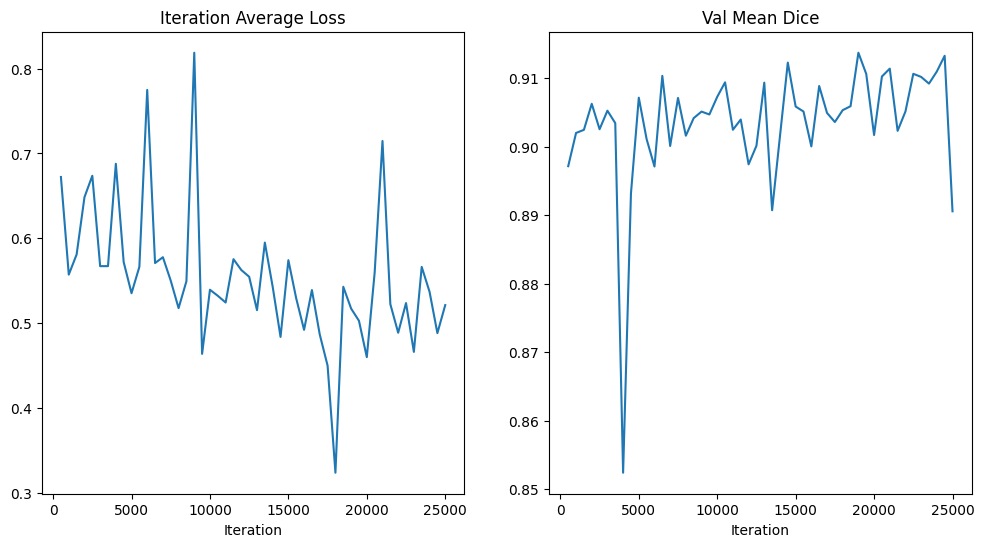

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

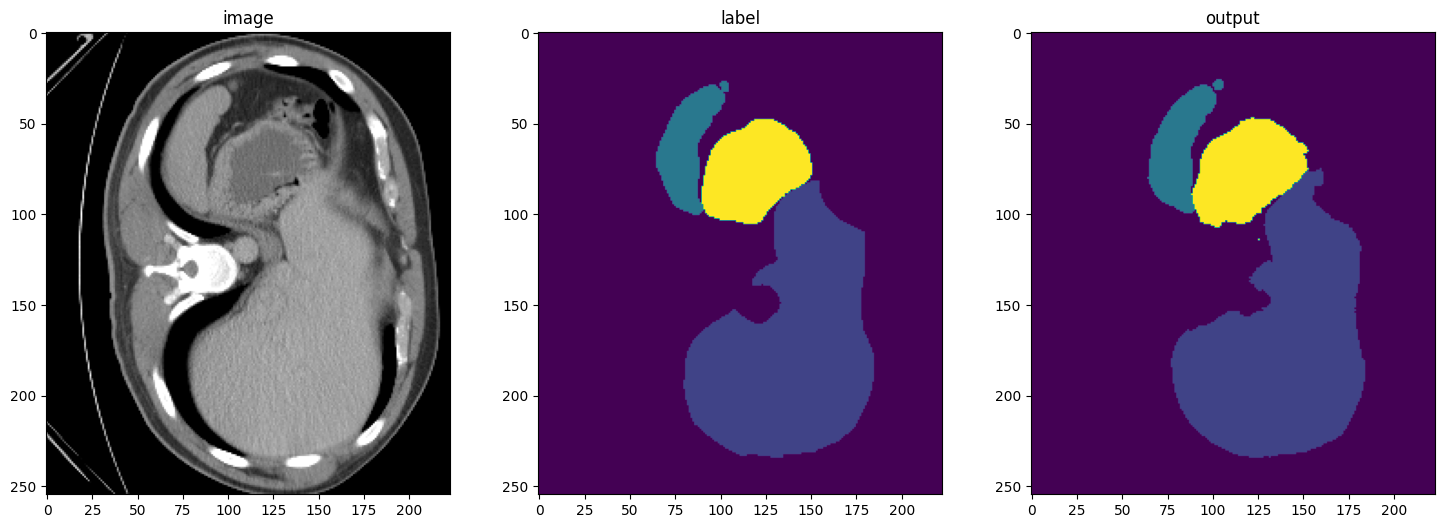

In [18]:
case_num = 1
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()